# Calculate song information contained in individual MA neurons

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

import warnings; warnings.filterwarnings("ignore")

from disp import set_plot


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

PFX_NRL = f'data/simple/mlv/ma_built/nrl/ma_built'

## Define complete neural population

In [2]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120, 180, 240, 480, 600])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)
r_cols = [f'R_{cr}' for cr in range(nr)]

# Compute information

In [3]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

In [4]:
# load all neural recordings
dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs = cc([np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)])

dfs_tr = None

In [5]:
dfs_tr_scrm = [np.load(f'{PFX_NRL}_scrm_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

it_song_starts_scrm = [np.nonzero(np.array(df_tr_scrm['Q']) == 0)[0][0] for df_tr_scrm in dfs_tr_scrm]
frs_scrm = cc([np.array(df_tr_scrm[R_COLS])[it_song_start_scrm:, :] for df_tr_scrm, it_song_start_scrm in zip(dfs_tr_scrm, it_song_starts_scrm)])

dfs_tr_scrm = None

In [6]:
len(frs)

1448116

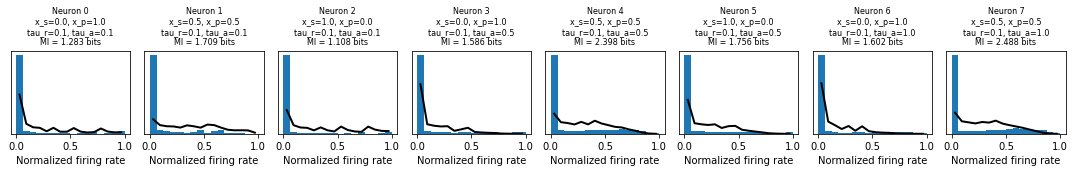

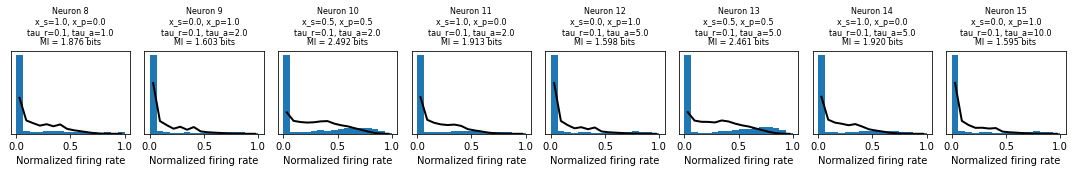

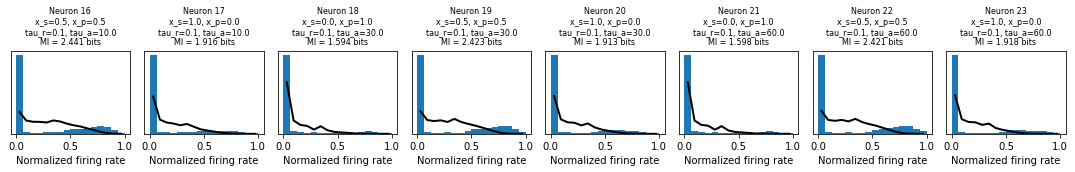

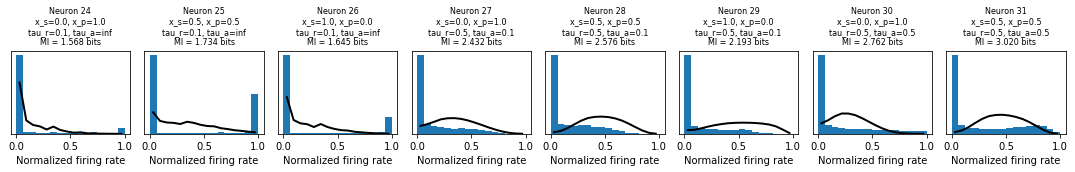

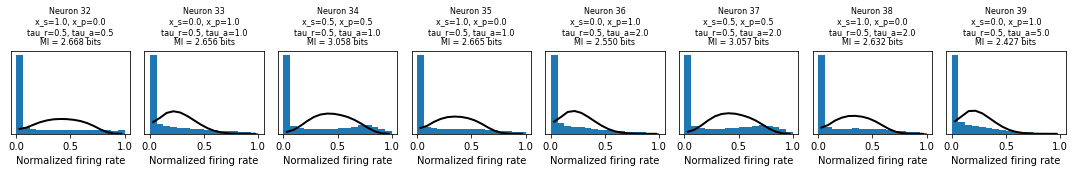

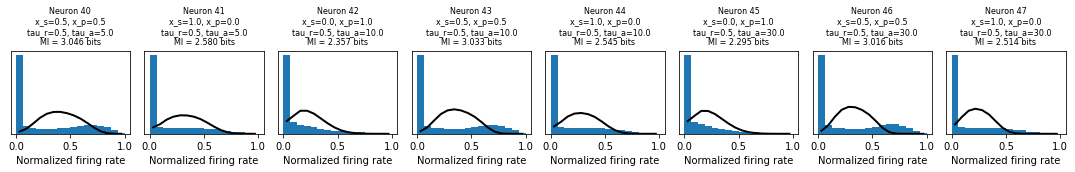

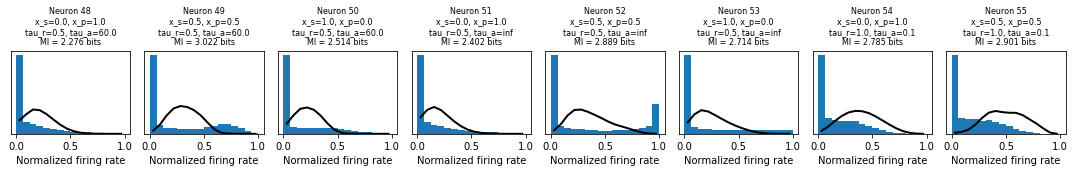

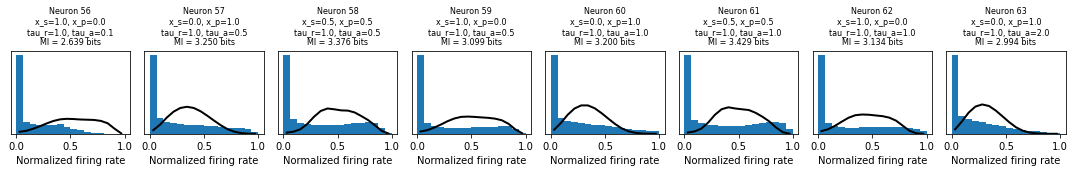

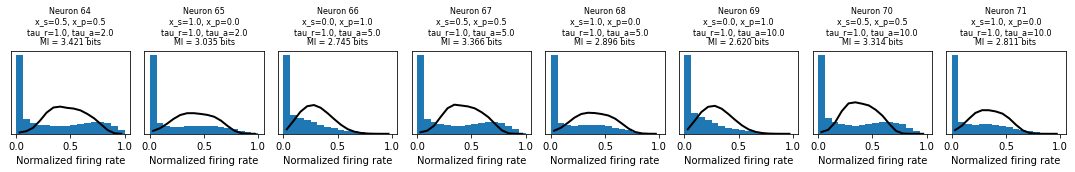

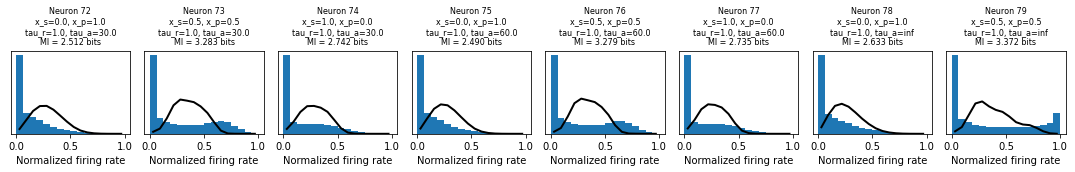

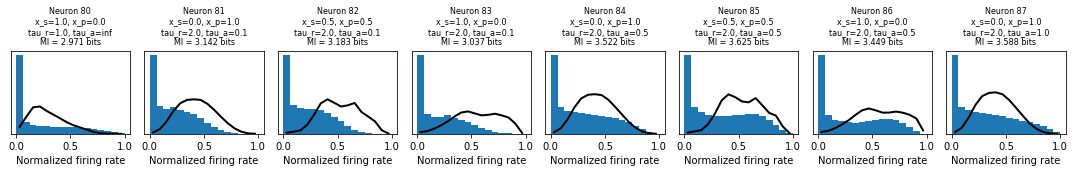

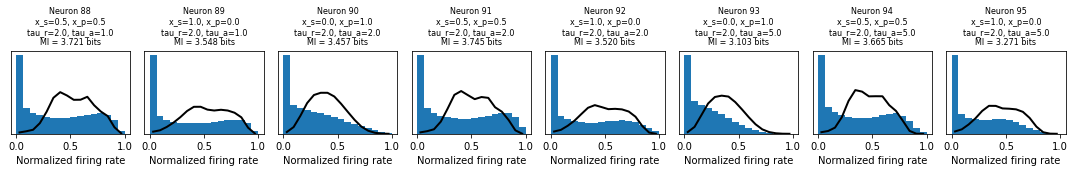

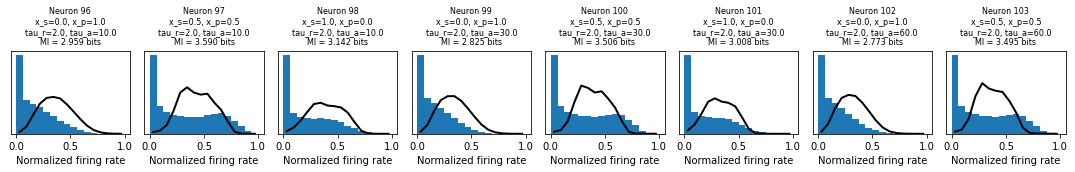

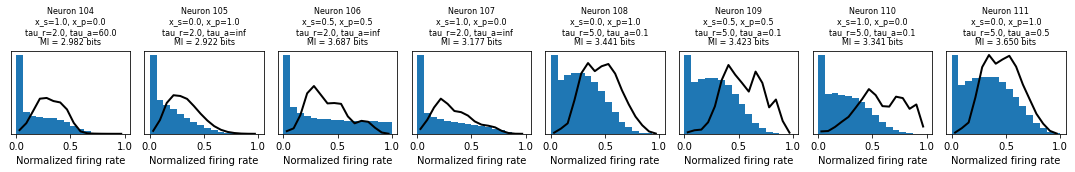

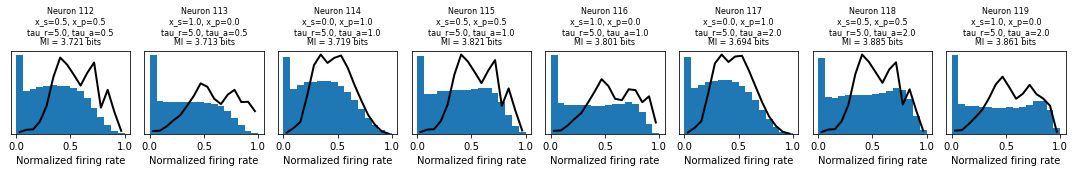

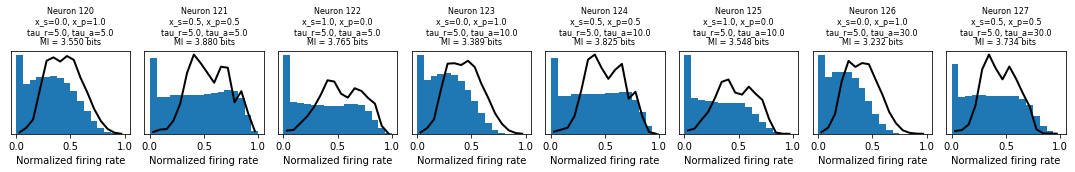

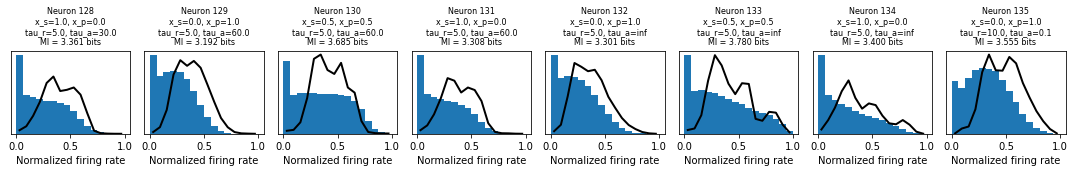

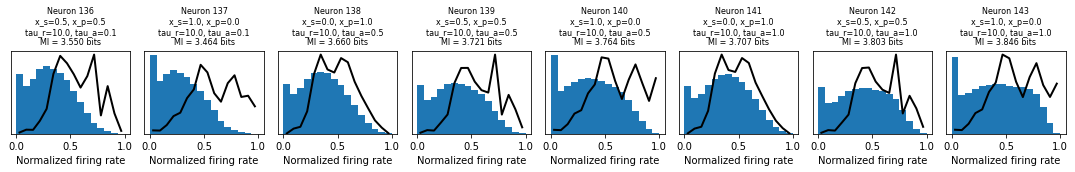

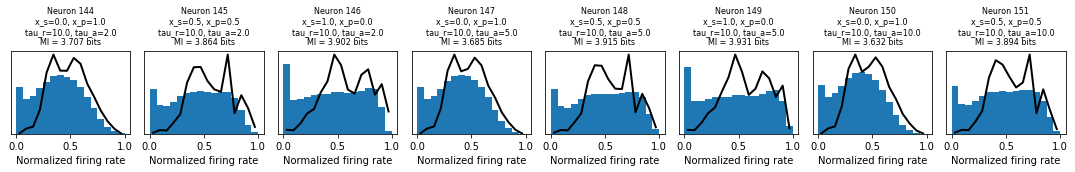

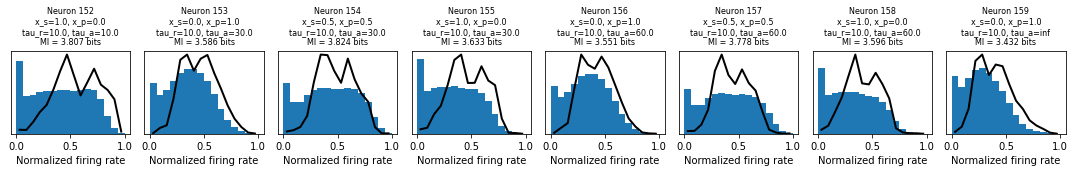

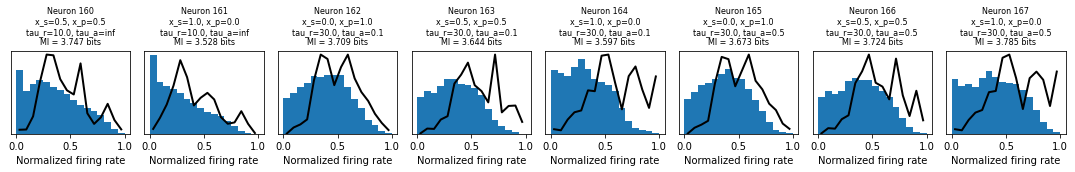

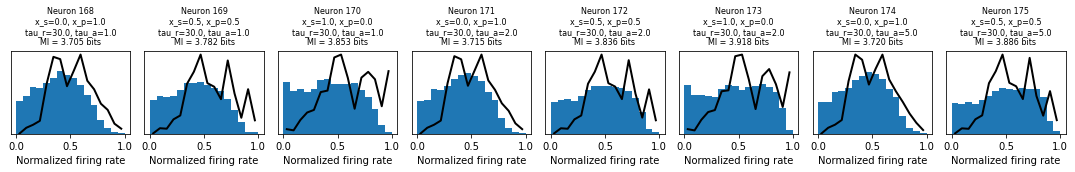

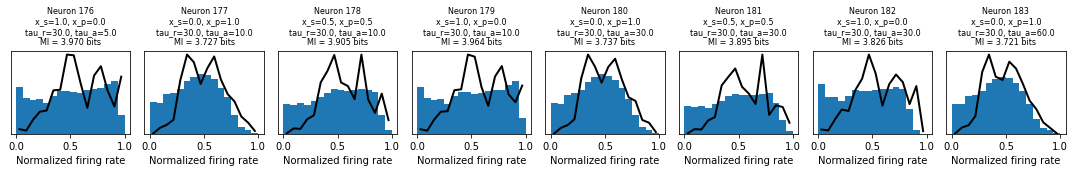

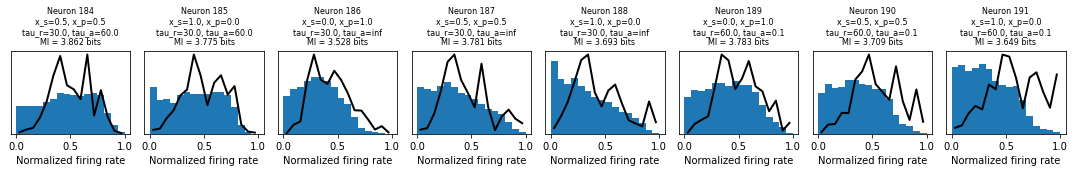

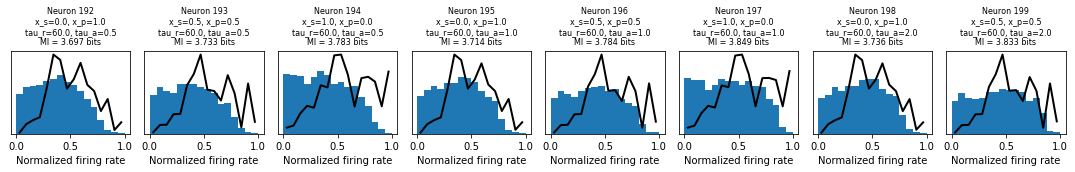

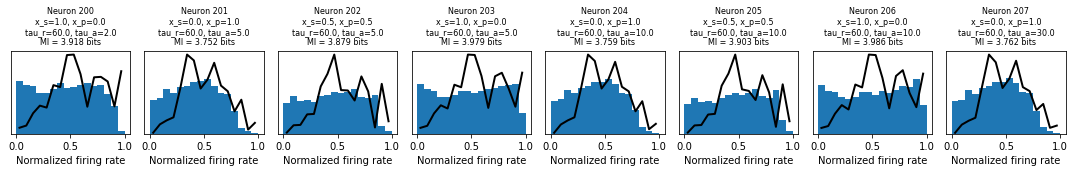

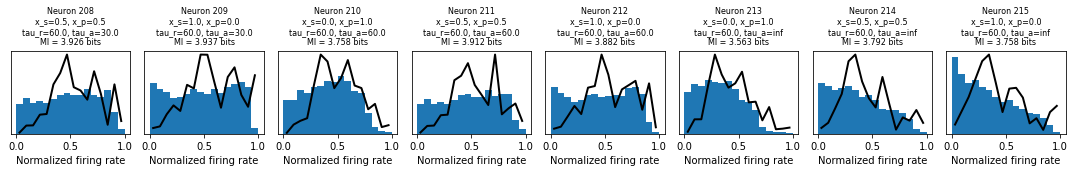

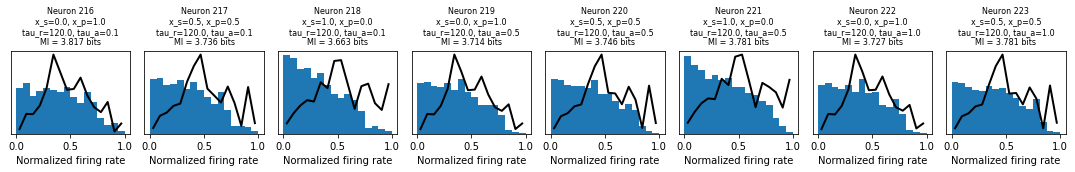

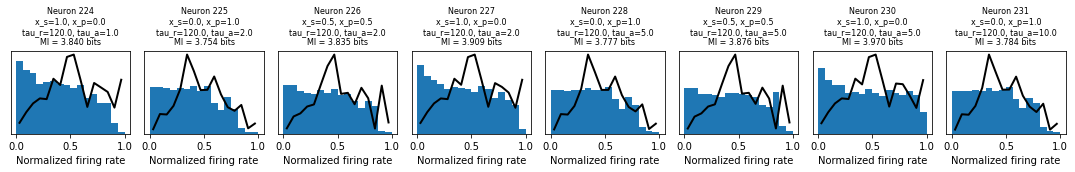

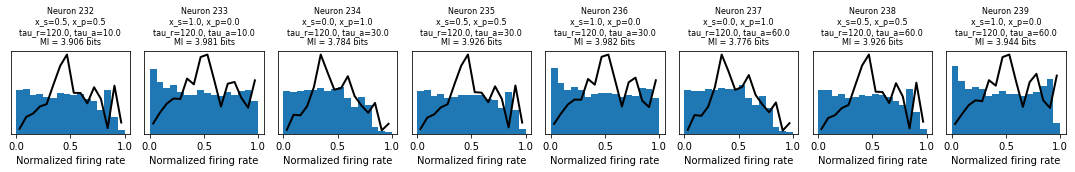

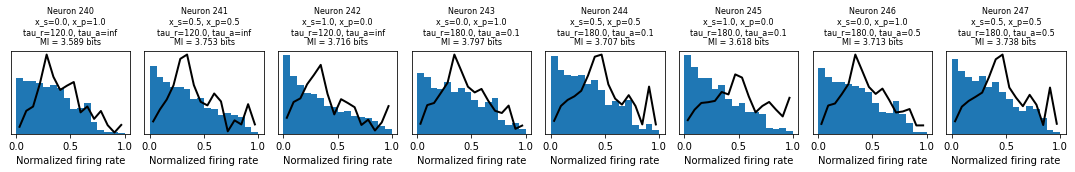

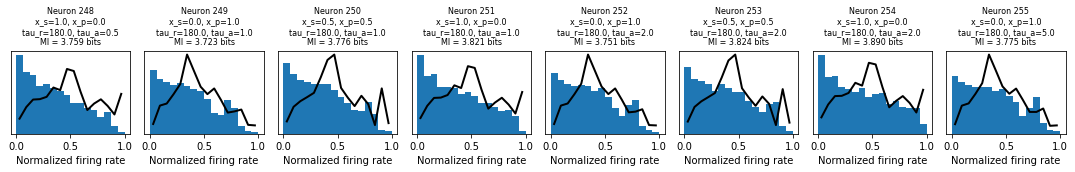

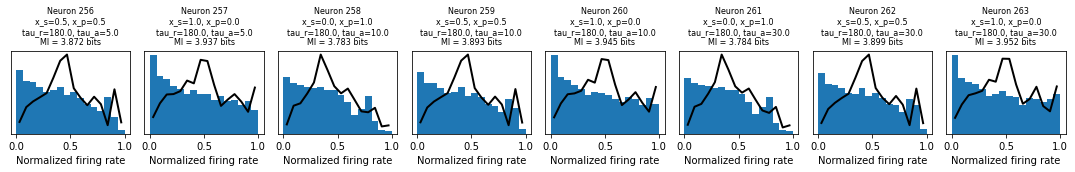

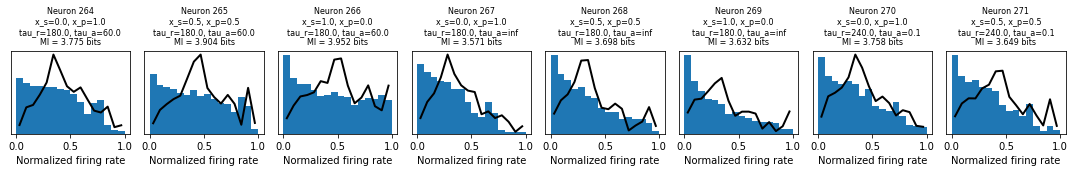

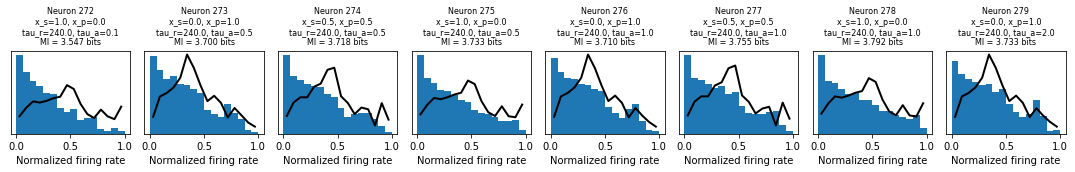

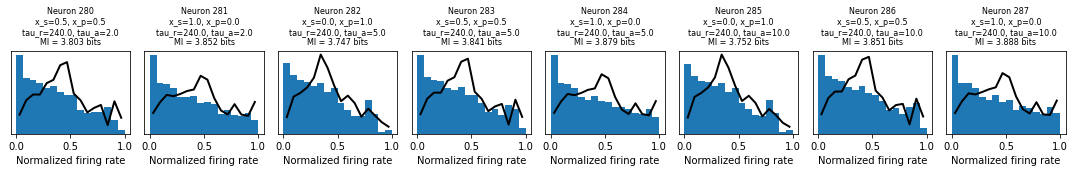

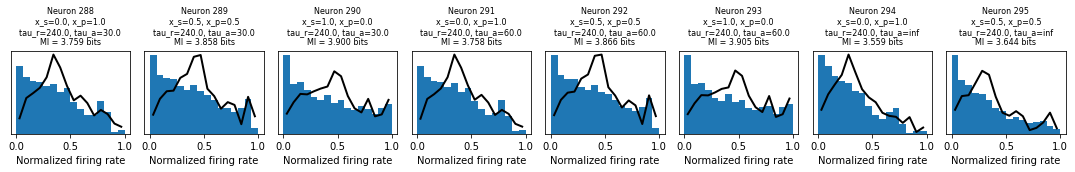

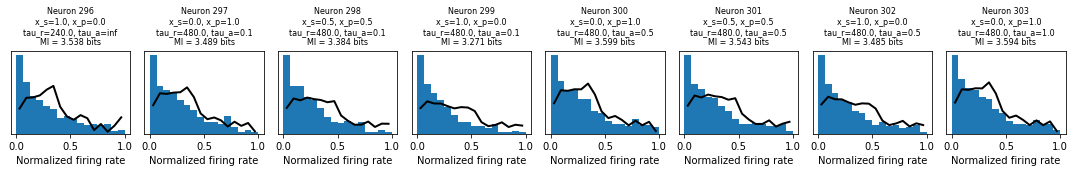

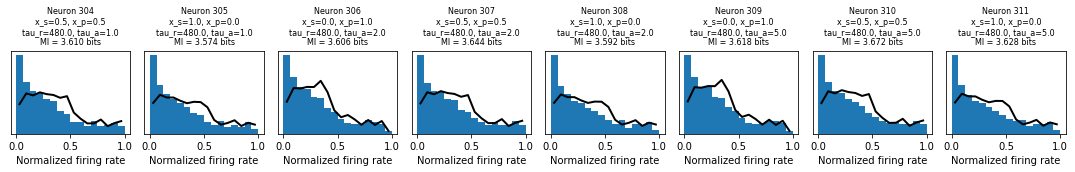

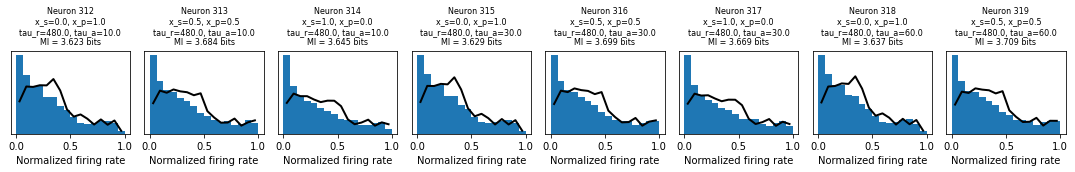

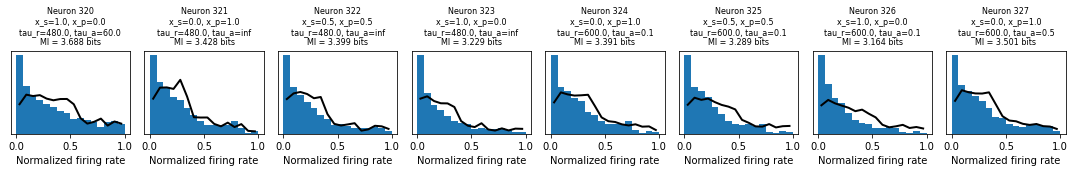

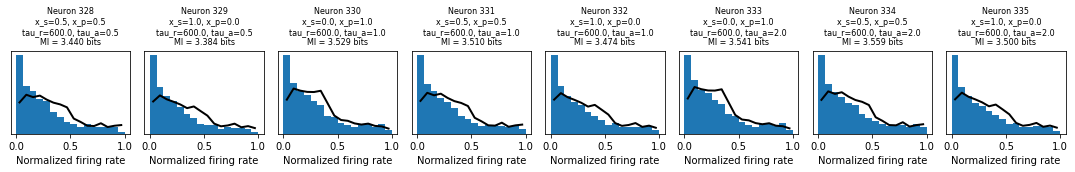

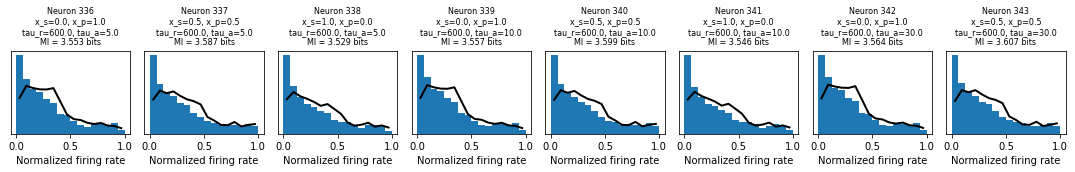

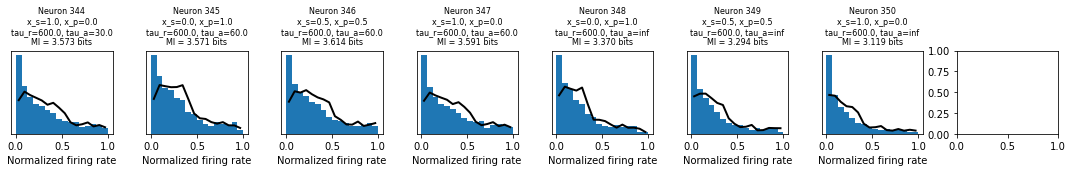

In [6]:
BINS = np.linspace(0, 1, 16+1)
BINC = .5*(BINS[:-1] + BINS[1:])

ncol = 8
cnrn = 0

hs = np.nan*np.zeros(nr)
hs_scrm = np.nan*np.zeros(nr)

for istart in range(0, frs.shape[1], ncol):
    fig, axs = plt.subplots(1, ncol, figsize=(15, 2.5), tight_layout=True)
    for ax, fr, fr_scrm in zip(axs, frs[:, istart:istart+ncol].T, frs_scrm[:, istart:istart+ncol].T):
        # song responses (normal histogram)
        fr /= fr.max()
        cts_fr = np.histogram(fr, bins=BINS)[0]
        p_fr = cts_fr/cts_fr.sum()
        
        h = stats.entropy(p_fr, base=2)
        hs[cnrn] = h 
        
        ax.bar(BINC, p_fr, width=(BINS[1] - BINS[0]))
        
        # responses to scrambled song (black line)
        fr_scrm /= fr_scrm.max()
        cts_fr_scrm = np.histogram(fr_scrm, bins=BINS)[0]
        binc = .5*(BINS[:-1] + BINS[1:])
        p_fr_scrm = cts_fr_scrm/cts_fr_scrm.sum()
        
        h_scrm = stats.entropy(p_fr_scrm, base=2)
        hs_scrm[cnrn] = h_scrm
        
        ax.plot(BINC, p_fr_scrm, c='k', lw=2)
        
        ax.set_xlabel('Normalized firing rate')
        ax.set_title(f'Neuron {cnrn}\nx_s={x_ss[cnrn]}, x_p={x_ps[cnrn]}\ntau_r={tau_rs[cnrn]:.1f}, tau_a={tau_as[cnrn]:.1f}\nMI = {h:.3f} bits', fontsize=8)
        ax.yaxis.set_visible(False)
        cnrn += 1

Save response entropies

In [7]:
np.save(
    'data/simple/compression/single_nrn_rsp_entropies.npy',
    np.array([{
        'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps,
        'HS': hs, 'HS_SCRM': hs_scrm
    }]))

Main text example response distributions

INRN 52: TAU_R=0.5, TAU_A=inf, X_S=0.5, X_P=0.5, H=2.8888, H_SCRM=3.5142
INRN 241: TAU_R=120.0, TAU_A=inf, X_S=0.5, X_P=0.5, H=3.7535, H_SCRM=3.6799
INRN 206: TAU_R=60.0, TAU_A=10.0, X_S=1.0, X_P=0.0, H=3.9855, H_SCRM=3.7715
INRN 121: TAU_R=5.0, TAU_A=5.0, X_S=0.5, X_P=0.5, H=3.8796, H_SCRM=3.5642


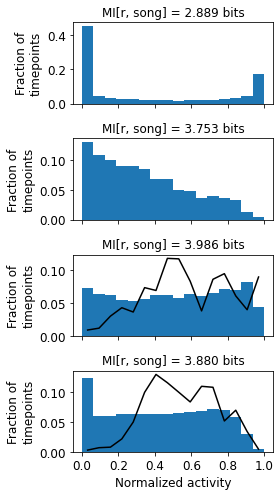

In [8]:
INRNS_HIST = [52, 241, 206, 121]
SHOW_SCRM = [False, False, True, True]

fig, axs = plt.subplots(len(INRNS_HIST), 1, figsize=(4, 1.75*len(INRNS_HIST)), tight_layout=True, sharex=True)
for ax, inrn, show_scrm in zip(axs, INRNS_HIST, SHOW_SCRM):
    fr = frs[:, inrn] / frs[:, inrn].max()
    
    cts = np.histogram(fr, bins=BINS)[0]
    p_fr = cts/cts.sum()
    
    h = stats.entropy(p_fr, base=2)
    
    ax.bar(binc, p_fr, width=(BINS[1] - BINS[0]))
    
    fr_scrm = frs_scrm[:, inrn] / frs_scrm[:, inrn].max()
    cts_scrm = np.histogram(fr_scrm, bins=BINS)[0]
    p_fr_scrm = cts_scrm/cts_scrm.sum()

    h_scrm = stats.entropy(p_fr_scrm, base=2)
        
    if show_scrm:
        ax.plot(BINC, p_fr_scrm, c='k')
        
    tau_r = tau_rs[inrn]
    tau_a = tau_as[inrn]
    x_s = x_ss[inrn]
    x_p = x_ps[inrn]
    
    print(f'INRN {inrn}: TAU_R={tau_r}, TAU_A={tau_a}, X_S={x_s}, X_P={x_p}, H={h:.4f}, H_SCRM={h_scrm:.4f}')
        
    if ax is axs[-1]:
        set_plot(ax, x_label='Normalized activity')
    set_plot(
        ax, y_label='Fraction of\ntimepoints',
        title=f'MI[r, song] = {h:.3f} bits', font_size=12)
    
fig.savefig('ms/fig_3abcd.svg')